In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1234)

## Parameters
N = 24
T = 50
c = 0.6  # 0.4   # 0.7
r = 1.4 # 0.5  # 0.7
p_loss = 0.5

In [2]:
def Flattened_to_2DIndex(Array, n):
    '''
    Array: 1d enumeration of a previously n x n shaped array
    n: integer with len(Array) == n*n
    '''
    assert(len(Array) == n*n)
    i_index = (Array/n).astype(int)
    j_index = Array%n
    output = np.empty((n*n,2))
    output[:,0] = i_index
    output[:,1] = j_index
    return(output)



def Sample_Agent_B(N_agents, Indices_A):
    '''
    N_agents: integer (number of agents)
    Indices_A: 2d integer array (kth row of this array gives the x/y coordinates of agent k)
    '''
    
    # create 2d enumeration and flatten it
    Enumeration = np.arange(0,N_agents*N_agents).reshape((N_agents,N_agents))
    FlatEnumeration = Enumeration.flatten()
    
    # transform the flattened enumeration to (i,j) indices of the 2d map
    indices = Flattened_to_2DIndex(FlatEnumeration, N_agents)

    # Calculate the L1 Distances from the Indices of A
    Norm  = (abs(indices - Indices_A)).sum(axis = 1)
    Norm.reshape((N_agents,N_agents))
    # Safety check
    #ax = sns.heatmap(Norm.reshape((N_agents,N_agents)), linewidth=0.5)
    #plt.title("Distances")
    #plt.show()
    
    # Now create a list of only those indices that are exactly 1 distance away from A
    ListIndices_Neighbours_A = list(indices[Norm == 1])
    
    return(ListIndices_Neighbours_A)
    
    

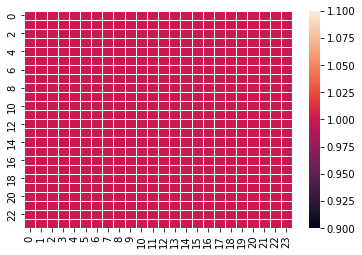

Time unit 0
Mean 1.3828715599661767
Median 1.0
Number of contracts 534


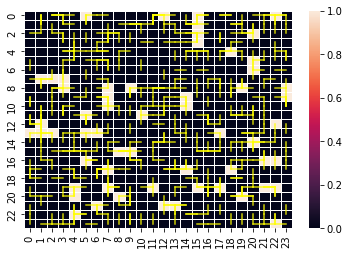



Time unit 1
Mean 2.11064785306608
Median 1.0
Number of contracts 481


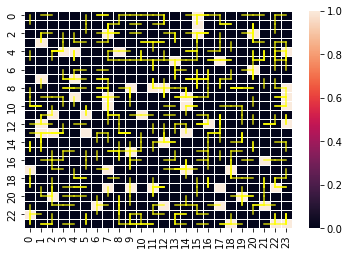



Time unit 2
Mean 3.5500994348593746
Median 1.05673250722741
Number of contracts 487


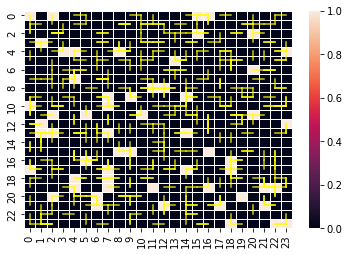



Time unit 3
Mean 4.871828457374876
Median 1.133606409543144
Number of contracts 471


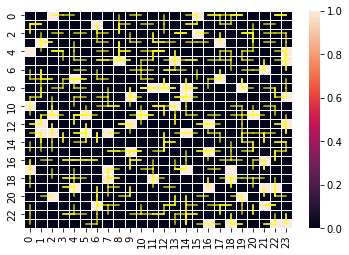



Time unit 4
Mean 8.190349691437287
Median 1.2062344621539653
Number of contracts 472


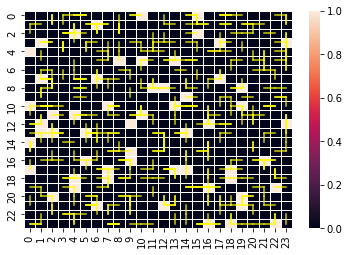



Time unit 5
Mean 10.450735749183558
Median 1.3540032552647525
Number of contracts 480


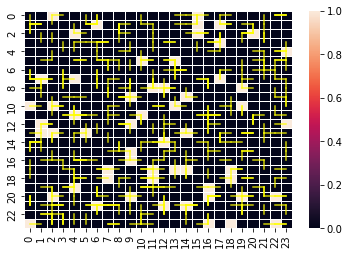



Time unit 6
Mean 15.150774757822912
Median 1.5085563931003367
Number of contracts 492


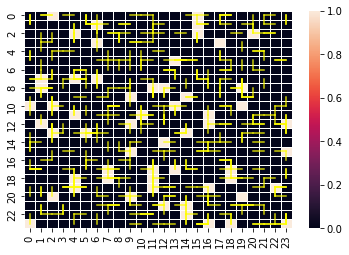



Time unit 7
Mean 14.57175386228734
Median 1.768021557895957
Number of contracts 490


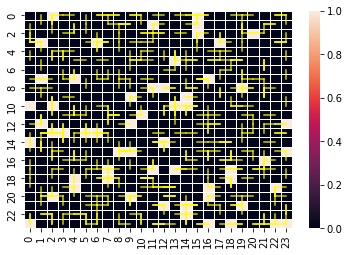



Time unit 8
Mean 16.678333473506434
Median 1.9892033641903342
Number of contracts 494


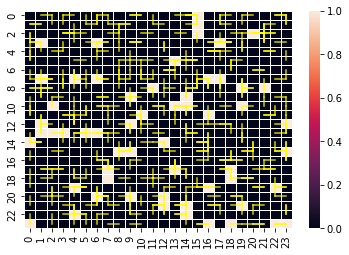



Time unit 9
Mean 28.697788159343798
Median 2.2235785974353393
Number of contracts 490


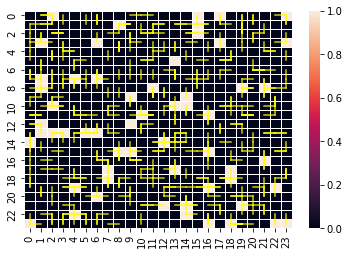



Time unit 10
Mean 44.293319983487336
Median 2.4306545730907265
Number of contracts 492


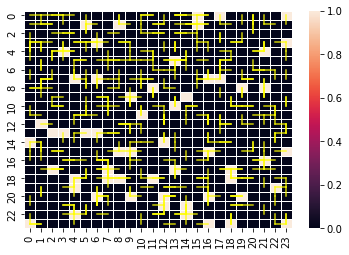



Time unit 11
Mean 30.55323831722569
Median 2.6942111832562694
Number of contracts 480


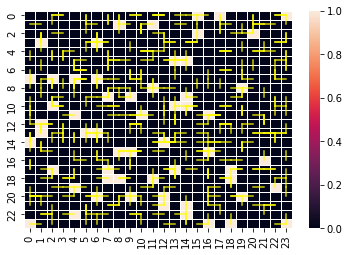



Time unit 12
Mean 34.552686210871016
Median 3.01430215325722
Number of contracts 499


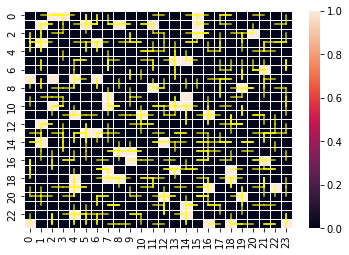



Time unit 13
Mean 49.35449730998156
Median 3.39072433115349
Number of contracts 502


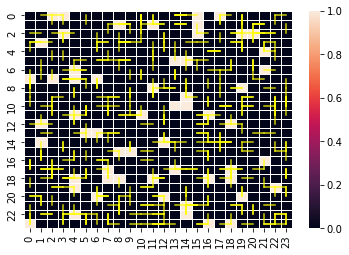



Time unit 14
Mean 56.50370115495439
Median 3.943098493709657
Number of contracts 495


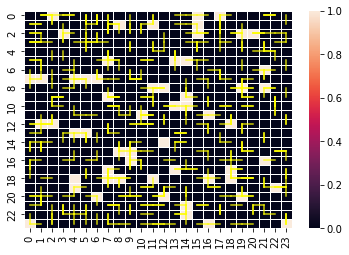



Time unit 15
Mean 97.39353133429283
Median 4.62937688348265
Number of contracts 518


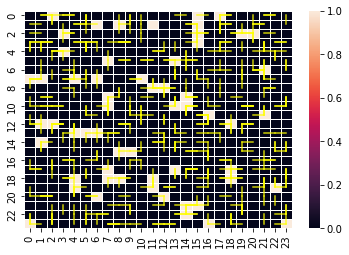



Time unit 16
Mean 97.64702482205972
Median 5.315930719481555
Number of contracts 507


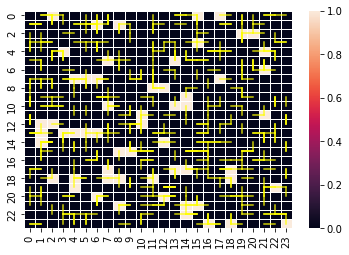



Time unit 17
Mean 164.93504987491502
Median 5.688422645411917
Number of contracts 495


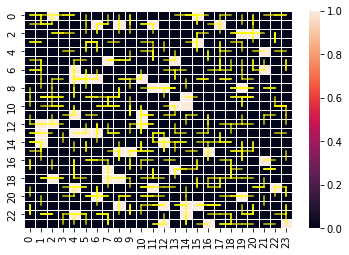



Time unit 18
Mean 268.3168357238105
Median 6.449376791425111
Number of contracts 506


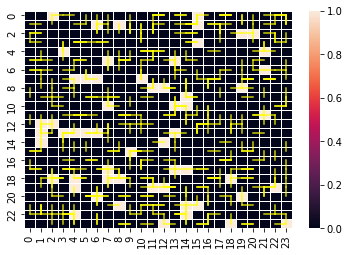



Time unit 19
Mean 274.2944310185096
Median 7.497404654441471
Number of contracts 500


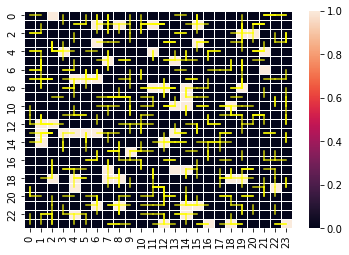



Time unit 20
Mean 557.0193120581555
Median 8.904538473734371
Number of contracts 497


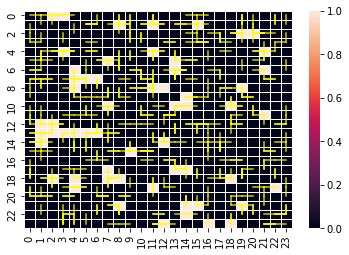



Time unit 21
Mean 1613.8149393164967
Median 9.752653808594664
Number of contracts 494


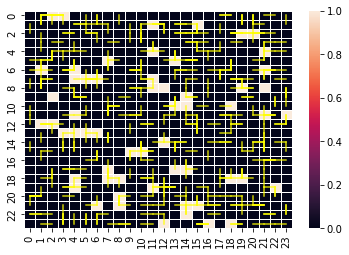



Time unit 22
Mean 2721.584580855501
Median 11.287245518060054
Number of contracts 496


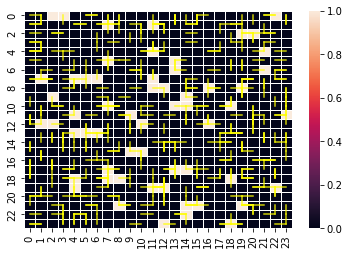



Time unit 23
Mean 3906.4693532099172
Median 13.134267267708871
Number of contracts 503


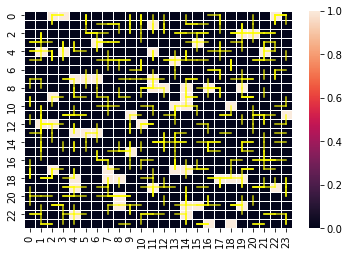



Time unit 24
Mean 3656.4051646253743
Median 14.629228673100144
Number of contracts 492


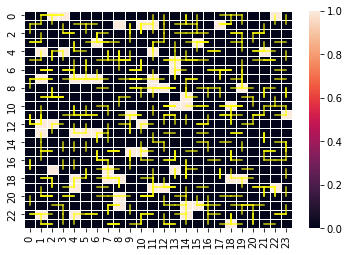



Time unit 25
Mean 2032.0185282350026
Median 17.29104519627009
Number of contracts 504


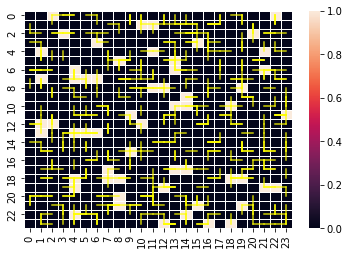



Time unit 26
Mean 4295.460683084803
Median 19.97177812614042
Number of contracts 498


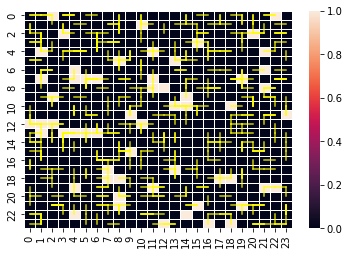



Time unit 27
Mean 15113.974496873761
Median 22.62037855221569
Number of contracts 501


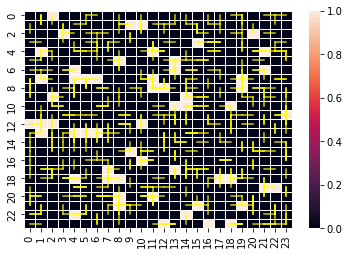



Time unit 28
Mean 20685.97556839492
Median 25.886221632718502
Number of contracts 521


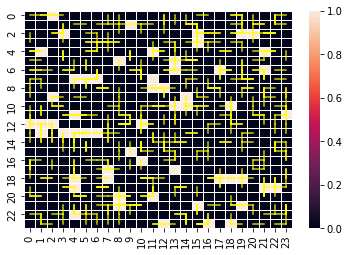



Time unit 29
Mean 36056.619037491255
Median 28.15064725852805
Number of contracts 505


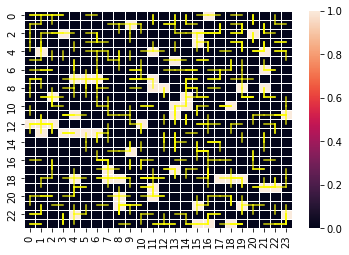



Time unit 30
Mean 42072.973032157606
Median 33.01103966827688
Number of contracts 509


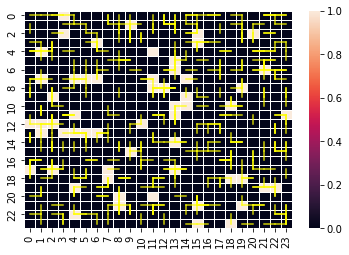



Time unit 31
Mean 193607.92919427884
Median 38.58712403952704
Number of contracts 502


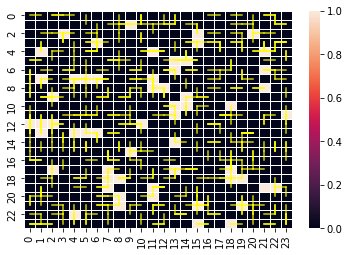



Time unit 32
Mean 99873.75468127061
Median 45.68976643992639
Number of contracts 516


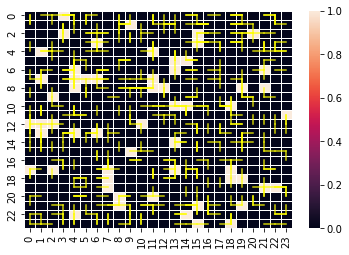



Time unit 33
Mean 25244.77847216332
Median 51.637235545888586
Number of contracts 512


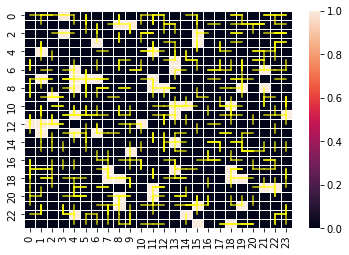



Time unit 34
Mean 47557.6517970195
Median 60.48198354399676
Number of contracts 507


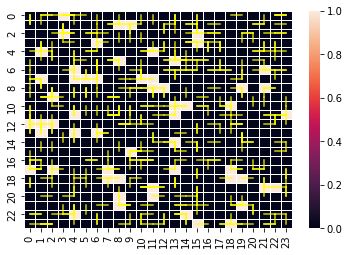



Time unit 35
Mean 196011.6047479946
Median 67.18684479781035
Number of contracts 512


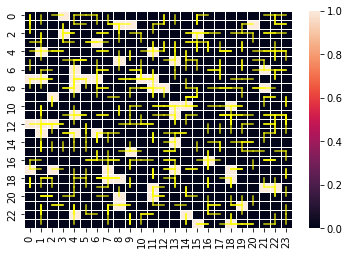



Time unit 36
Mean 384079.672255462
Median 76.22090110708758
Number of contracts 513


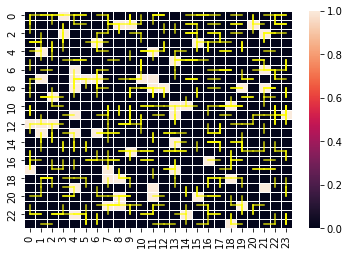



Time unit 37
Mean 382680.5241422768
Median 88.41347863503137
Number of contracts 518


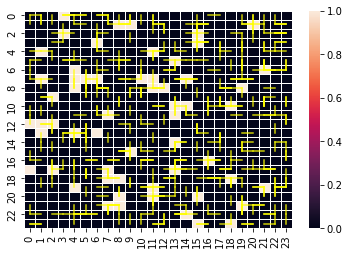



Time unit 38
Mean 163318.15409403192
Median 104.14501582437998
Number of contracts 502


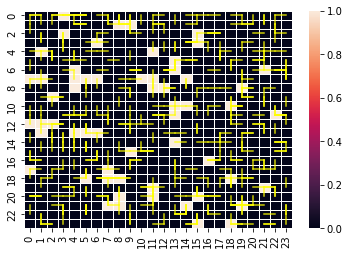



Time unit 39
Mean 159385.94252459443
Median 126.69319994073867
Number of contracts 510


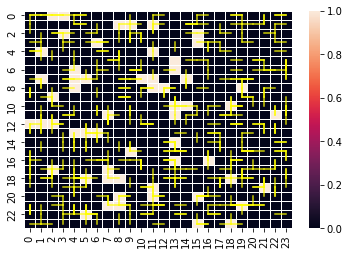



Time unit 40
Mean 355641.07485855214
Median 141.82227486860376
Number of contracts 511


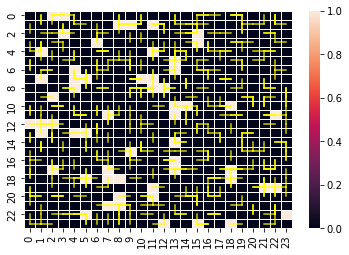



Time unit 41
Mean 200694.55093051255
Median 168.12916411708372
Number of contracts 510


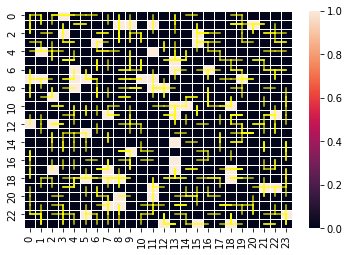



Time unit 42
Mean 382502.4605065945
Median 207.17068918121572
Number of contracts 511


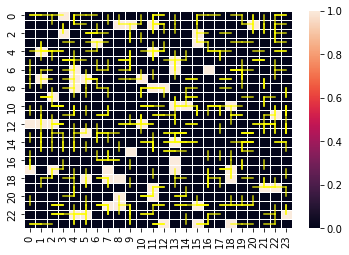



Time unit 43
Mean 994123.7991082246
Median 237.6205329878951
Number of contracts 518


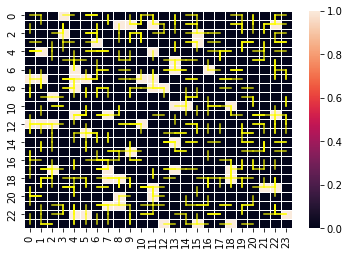



Time unit 44
Mean 3902757.1584961
Median 280.3024740630816
Number of contracts 519


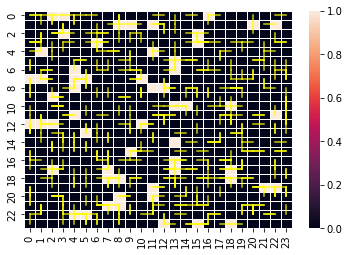



Time unit 45
Mean 9160994.107316397
Median 319.6017779694327
Number of contracts 513


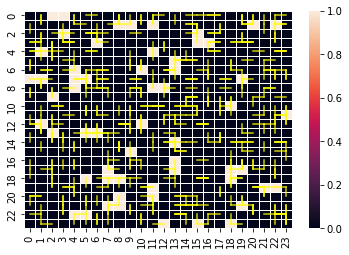



Time unit 46
Mean 4372459.845473836
Median 375.2946954712707
Number of contracts 503


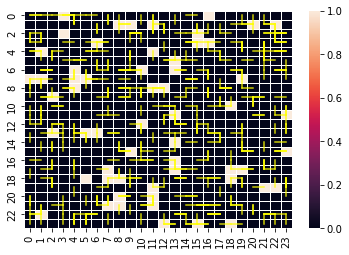



Time unit 47
Mean 2235971.1747537134
Median 433.4261443441859
Number of contracts 502


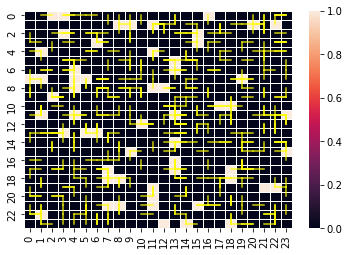



Time unit 48
Mean 3804796.6545105553
Median 496.4352786359072
Number of contracts 516


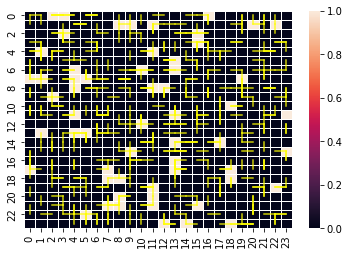



Time unit 49
Mean 1768022.6069817313
Median 555.2521447563797
Number of contracts 523


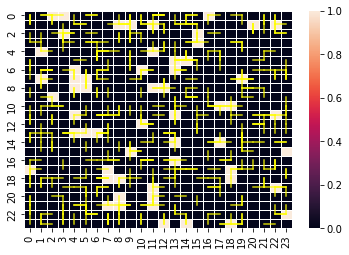

In [3]:
AgentsTimeSeries = np.ones((N,N,T+1))


Agents = np.ones((N,N))
AgentsTimeSeries[:,:,0] = Agents
ax = sns.heatmap(Agents, linewidth=0.5)
plt.show()


for t in range(T):  # time units
    
    Contracts = list()
    Distances = list()
    
    for n in range(N*N): # time steps
        
        
        
        # A has the risk and wants to buy insurance
        i_A = np.random.randint(0,N)
        j_A = np.random.randint(0,N)
        
        # Wealth of A and associated cost/gain and maximum Fee
        w_A = Agents[i_A,j_A]
        G = r*w_A
        C = c*w_A
        F_max = w_A - ((w_A + G)**0.5) * ((w_A-C)**0.5)

        
        
        # Neighbourhood of A
        Neighbourhood = Sample_Agent_B(N_agents = N, 
                                       Indices_A = np.array([i_A,j_A]).astype(int))
        Neighbourhood_Offers = dict() # store the F_min offer of each neighbour
        Neighbourhood_Coordinates = dict() # store the coordinates/indices of neighbours
        Neighbours = 0 # enumeration of the neighbours for dict
        for Agent in Neighbourhood:
            i_B, j_B = Agent.astype(int)
            w_B = Agents[i_B, j_B]
            F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.
            Neighbourhood_Coordinates[Neighbours] = Agent
            Neighbourhood_Offers[Neighbours] = F_min
            Neighbours += 1
        
        # Identify best offer:
        B = min(Neighbourhood_Offers, key=Neighbourhood_Offers.get)
        i_B, j_B = Neighbourhood_Coordinates[B].astype(int)
        w_B = Agents[i_B, j_B]
        F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.

        '''
        print("###########")
        print("A",i_A, j_A)
        print("Positions", Neighbourhood_Coordinates)
        print("Offers", Neighbourhood_Offers)
        print("B", B)
        '''
        
        # Now Gamble
        p = np.random.uniform(0,1)
        win = p>p_loss
        
        if (F_min >= F_max) or (w_B <= C): 
            # B demands more than A is willing to pay:
            # no contract
            
            if win:
                Agents[i_A, j_A] *= (1+r)
            else:
                Agents[i_A,j_A] *= (1-c)
                
                
        elif F_min < F_max and (w_B > C):
            # make a contract at midway fee
            F = 0.5*(F_min + F_max) 
            
            Agents[i_A,j_A] -= F 
            
            
            Contracts += [(i_A, j_A, i_B, j_B)]  # record the signed contract
            #print(Contracts[-1])
            #print(F_min, F, F_max)
            #print(i_A, j_A, i_B, j_B)
            #print("\n")
            if win:
                Agents[i_B, j_B] += (F +  G)
            else:
                Agents[i_B, j_B] += (F-C)
            

    
    
    
    print("Time unit", t)
    print("Mean", np.mean(Agents))
    print("Median", np.median(Agents))
    #ax = sns.heatmap(np.log(Agents), linewidth=0.5)
    ax = sns.heatmap(Agents>np.quantile(Agents,0.9), linewidth=0.5)  # Plot the extreme few %
    # now plot the contracts of this time unit
    
    print("Number of contracts", len(Contracts))
    
    for Indices in Contracts:
        i1, j1, i2, j2 = Indices
        #print([j1,i1], [j2,i2])
        plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "yellow", alpha =0.8)
    #i1, j1, i2, j2 = Contracts[-1]
    #print([j1,i1], [j2,i2])
    #plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "white")
    
    
    plt.show()
    #print("Mean Distance for Contract", np.mean(np.array(Distances)))
    print("\n")
    
    AgentsTimeSeries[:,:,t+1] = Agents

Median 555.2521447563797
TA of EV player 0.3678283588651884


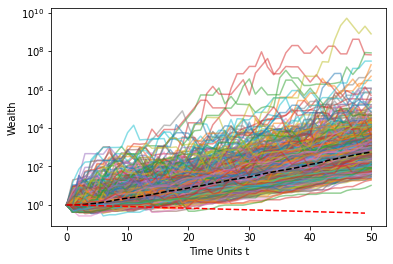

In [4]:
fig, ax = plt.subplots(1,1)
for i in range(N):
    for j in range(N):
        ax.semilogy(AgentsTimeSeries[i,j,:], alpha = 0.5)
        
medians = list()
for t in range(T+1):
    medians  += [np.median(AgentsTimeSeries[:,:,t])]
print("Median",medians[-1])     # 1.659e-13
ax.semilogy(medians, c = "k", linestyle= "--")
ax.set_xlabel("Time Units t")
ax.set_ylabel("Wealth")
#ax.semilogy([0,T],[1,1], c="k")

# Expectation

TA = np.ones(T)
TA =  ((1-c)**(p_loss) * (1+r)**(1-p_loss))**np.arange(T)
ax.semilogy(TA, c="red", linestyle = "--", label="Individual Time Average")
print("TA of EV player",TA[-1])
plt.show()


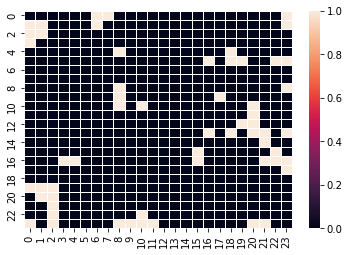

In [5]:
ax = sns.heatmap(Agents<np.quantile(Agents,0.1), linewidth=0.5)  # Plot the upper few %


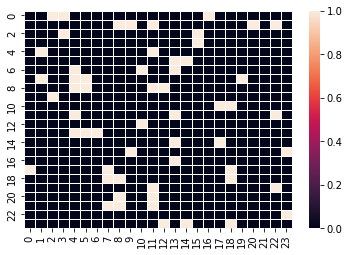

In [6]:
ax = sns.heatmap(Agents>np.quantile(Agents,0.9), linewidth=0.5)  # Plot the upper few %


It should be possible to, for both of those quantile groups, calculate how many of them have a next neighbour inside this quantile. That's similar to the clustering coefficient. Then, compare that a permuation of ranked agents (CIs via bootstrapping). One can then transition from next-neighbours to the exponential decay of the distance (but still choose 4 agents for each to choose from!) and see if the clustering is persistent or not.

## Calculate Clustering


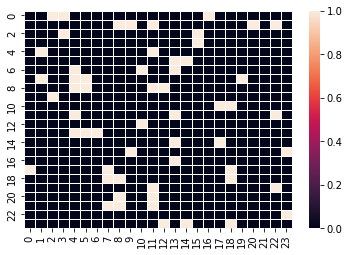

In [9]:
TopDecile = Agents>np.quantile(Agents,0.9)
ax = sns.heatmap(TopDecile, linewidth=0.5)  # Plot the upper few %


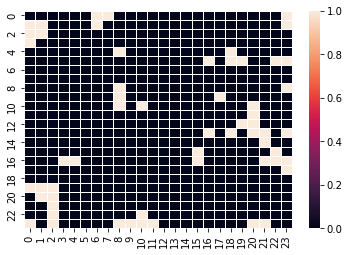

In [10]:

BottomDecile = Agents<=np.quantile(Agents,0.1)
ax = sns.heatmap(BottomDecile, linewidth=0.5)  # Plot the upper few %


In [32]:
def FilterNeighbours(Matrix, i, j):
    
    '''
    Given a 2d Matrix and an element i,j of this Matrix:
    return the Matrix indices which are next neighbours of this Matrix: [i+1,j] etc.
    But keep in mind the boundary condition: some elements only have 3 or 2 next neighbours, not four!
    '''
    
    m_mat,n_mat = Matrix.shape # dimensions of matrix: i<m, j<n
    Neighbours = np.zeros((4,2))
    Neighbours[0,:] = [i-1,j]
    Neighbours[1,:] = [i+1,j]
    Neighbours[2,:] = [i,j-1]
    Neighbours[3,:] = [i,j+1]
    
    # Now throw out those neighbours that are not within the matrix range
    
    Boolean = (Neighbours[:,0]> -1) & (Neighbours[:,0] < m_mat) & (Neighbours[:,1]> -1) & (Neighbours[:,1] < n_mat) 
    return(Neighbours[Boolean])

In [77]:
def NeighbourValues(Matrix, i, j):
    
    NeighboursIndices = FilterNeighbours(Matrix, i, j).astype(int)
    
    number_of_neighbours = NeighboursIndices.shape[0]
    
    Values_of_neighbours = np.empty(number_of_neighbours)
    
    for neighbour in range(number_of_neighbours):
        #print(neighbour,NeighboursIndices[neighbour,:])
        #print(Matrix[NeighboursIndices[neighbour][0],NeighboursIndices[neighbour][1]])
        Values_of_neighbours[neighbour] = Matrix[NeighboursIndices[neighbour][0],
                                                 NeighboursIndices[neighbour][1]]
        
    return(Values_of_neighbours)

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1.])

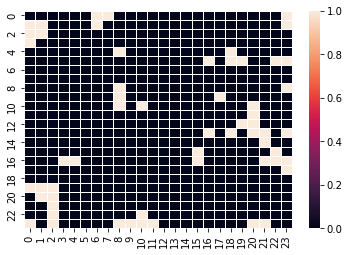

In [57]:
BottomDecile= BottomDecile.astype(float)

ax = sns.heatmap(BottomDecile, linewidth=0.5)  # Plot the upper few %
BottomDecile[0,:]

In [109]:
Selection = list()

mat = BottomDecile

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):   
        
        # only check for the selected entries if they are clustered
        if mat[i,j] == 1:
            neighbourhood = NeighbourValues(mat, i,j)
            #print(i,j, mat[i,j], neighbourhood.sum())
            
            if neighbourhood.sum() > 0:
                Selection += [1]
            else:
                Selection += [0]
                
Selection = np.array(Selection)

            

In [110]:
Selection.mean(), Selection.sum(), len(Selection)

(0.8448275862068966, 49, 58)

In [104]:
Selection = list()

mat = TopDecile

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):   
        
        # only check for the selected entries if they are clustered
        if mat[i,j] == 1:
            neighbourhood = NeighbourValues(mat, i,j)
            #print(i,j, mat[i,j], neighbourhood.sum())
            
            if neighbourhood.sum() > 0:
                Selection += [1]
            else:
                Selection += [0]
                
Selection = np.array(Selection)

Selection.mean()      

0.5517241379310345

In [106]:
Selection.sum(), len(Selection)

(32, 58)

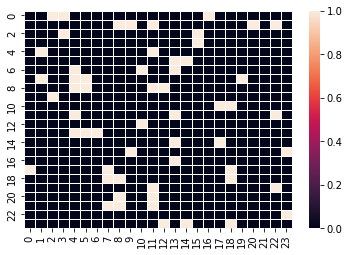

In [107]:
ax = sns.heatmap(TopDecile, linewidth=0.5)  # Plot the upper few %
